In [4]:
#import zipfile
#import os

# Define the zip file path and extraction directory
#zip_file_path = 'HelthAnalytics_data_zip.zip'
#extract_to = './extracted_data/'  # You can set this to your desired extraction path

# Create the extraction directory if it doesn't exist
#os.makedirs(extract_to, exist_ok=True)

# Unzip the file
#with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
#    zip_ref.extractall(extract_to)

#print(f'File extracted to {extract_to}')


# Create s3 bucket

In [89]:
import boto3
import sagemaker

session = boto3.session.Session()
region = session.region_name
sagemaker_session = sagemaker.Session()
bucket = sagemaker_session.default_bucket()

s3 = boto3.Session().client(service_name="s3", region_name=region)

In [90]:
setup_s3_bucket_passed = False

# Verify S3_BUCKET Bucket Creation

In [91]:
from botocore.client import ClientError

response = None

try:
    response = s3.head_bucket(Bucket=bucket)
    print(response)
    setup_s3_bucket_passed = True
except ClientError as e:
    print("[ERROR] Cannot find bucket {} in {} due to {}.".format(bucket, response, e))

{'ResponseMetadata': {'RequestId': '8SZ6P1W3GBXH3391', 'HostId': 'O2wmbBg/LeP45G/hDbKpS/d8WRi9gCmHToHcdMDpzUqAlGVSLxtc/4wtPvh2VbEPF0SwUqhnMT8=', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amz-id-2': 'O2wmbBg/LeP45G/hDbKpS/d8WRi9gCmHToHcdMDpzUqAlGVSLxtc/4wtPvh2VbEPF0SwUqhnMT8=', 'x-amz-request-id': '8SZ6P1W3GBXH3391', 'date': 'Thu, 26 Sep 2024 03:35:34 GMT', 'x-amz-bucket-region': 'us-east-1', 'x-amz-access-point-alias': 'false', 'content-type': 'application/xml', 'server': 'AmazonS3'}, 'RetryAttempts': 0}, 'BucketRegion': 'us-east-1', 'AccessPointAlias': False}


In [92]:
%store setup_s3_bucket_passed

Stored 'setup_s3_bucket_passed' (bool)


In [93]:
%store -r setup_dependencies_passed

In [94]:
%store

Stored variables and their in-db values:
ingest_create_athena_db_passed                    -> True
ingest_create_athena_table_csv_passed             -> True
s3_final_csv                                      -> 's3://sagemaker-us-east-1-284926681852/final_proje
s3_private_path_csv                               -> 's3://sagemaker-us-east-1-284926681852/homework_2_
s3_private_path_tsv                               -> 's3://sagemaker-us-east-1-284926681852/amazon-revi
setup_dependencies_passed                         -> True
setup_s3_bucket_passed                            -> True


In [95]:
try:
    setup_dependencies_passed
except NameError:
    print("+++++++++++++++++++++++++++++++")
    print("[ERROR] YOU HAVE TO RUN ALL NOTEBOOKS IN THE SETUP FOLDER FIRST. You are missing Setup Dependencies.")
    print("+++++++++++++++++++++++++++++++")

In [96]:
s3_final_csv = "s3://{}/final_project_cvs".format(bucket)

print(s3_final_csv)

s3://sagemaker-us-east-1-284926681852/final_project_cvs


In [97]:
%store s3_final_csv

Stored 's3_final_csv' (str)


In [98]:
print(s3_final_csv)

s3://sagemaker-us-east-1-284926681852/final_project_cvs


In [14]:
!aws s3 cp "/home/sagemaker-user/aai_540/extracted_data/healthcare/train_data.csv" $s3_final_csv/

# This command did not work inside Python. So I manually used AWS CLI to ingest the data. The command used is:  

# aws s3 cp /home/sagemaker-user/aai_540/extracted_data/healthcare/train_data.csv s3://sagemaker-us-east-1-284926681852/final_project_cvs/train_data.csv


The user-provided path /home/sagemaker-user/aai_540/extracted_data/healthcare/train_data.csv does not exist.


In [99]:
!aws s3 ls $s3_final_csv/

2024-09-26 03:19:09   26915575 train_data.csv


In [100]:
%store

Stored variables and their in-db values:
ingest_create_athena_db_passed                    -> True
ingest_create_athena_table_csv_passed             -> True
s3_final_csv                                      -> 's3://sagemaker-us-east-1-284926681852/final_proje
s3_private_path_csv                               -> 's3://sagemaker-us-east-1-284926681852/homework_2_
s3_private_path_tsv                               -> 's3://sagemaker-us-east-1-284926681852/amazon-revi
setup_dependencies_passed                         -> True
setup_s3_bucket_passed                            -> True


# Import Athena

In [101]:
from pyathena import connect

# Create Athena Database

In [102]:
database_name = "dsoaws_finalproject"
table_name_csv = "traindata_csv"

In [103]:
for table in wr.catalog.get_tables(database=database_name):
    print(table["Name"])

traindata_csv


In [104]:
# Set S3 staging directory -- this is a temporary directory used for Athena queries
s3_staging_dir = "s3://{0}/athena/staging".format(bucket)

In [105]:
conn = connect(region_name=region, s3_staging_dir=s3_staging_dir)

In [106]:
create_statement = """
CREATE EXTERNAL TABLE IF NOT EXISTS {}.{}(
    case_id                               INT,
    Hospital_code                         INT,
    Hospital_type_code                    STRING,
    City_Code_Hospital                    INT,
    Hospital_region_code                  STRING,
    AvailableExtraRoomsinHospital         INT,
    Department                            STRING,
    Ward_Type                             STRING,
    Ward_Facility_Code                    STRING,
    Bed_Grade                             DOUBLE,
    patientid                             INT,
    City_Code_Patient                     DOUBLE,
    TypeofAdmission                       STRING,
    SeverityofIllness                     STRING,
    VisitorswithPatient                   INT,
    Age                                   STRING,
    Admission_Deposit                     DOUBLE,
    Stay                                  STRING
) 
ROW FORMAT DELIMITED 
FIELDS TERMINATED BY ',' 
LINES TERMINATED BY '\\n' 
LOCATION '{}' 
TBLPROPERTIES ('skip.header.line.count'='1')
""".format(database_name, table_name_csv, s3_final_csv)

# Start query execution (Assuming 'wr' refers to awswrangler)
wr.athena.start_query_execution(sql=create_statement, database=database_name)


'17acd23d-94b5-4f62-bc9e-00cf08d7aff9'

In [107]:
for table in wr.catalog.get_tables(database=database_name):
    print(table["Name"])

traindata_csv


In [116]:
#df2 = wr.athena.read_sql_query(sql="SELECT * FROM {} LIMIT 100000".format(table_name_csv), database=database_name)

In [110]:
statement = "CREATE DATABASE IF NOT EXISTS {}".format(database_name)
print(statement)

CREATE DATABASE IF NOT EXISTS dsoaws_finalproject


In [111]:
import pandas as pd

pd.read_sql(statement, conn)

/tmp/ipykernel_7887/3803073958.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  pd.read_sql(statement, conn)


""


In [112]:
statement = "SHOW DATABASES"

df_show = pd.read_sql(statement, conn)
df_show.head(5)

/tmp/ipykernel_7887/3999478089.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_show = pd.read_sql(statement, conn)


,database_name
0,default
1,dsoaws
2,dsoaws_finalproject
3,sagemaker_featurestore


In [113]:
if database_name in df_show.values:
    ingest_create_athena_db_passed = True

In [114]:
%store ingest_create_athena_db_passed

Stored 'ingest_create_athena_db_passed' (bool)


# EDA and Feature Engineering

In [3]:
import pandas as pd
df_traindata=pd.read_csv('extracted_data/healthcare/train_data.csv')

In [4]:
df_traindata.head()

,case_id,Hospital_code,Hospital_type_code,City_Code_Hospital,Hospital_region_code,AvailableExtraRoomsinHospital,Department,Ward_Type,Ward_Facility_Code,BedGrade,patientid,City_Code_Patient,TypeofAdmission,SeverityofIllness,VisitorswithPatient,Age,Admission_Deposit,Stay
0,1,8,c,3,Z,3,radiotherapy,R,F,2.0,31397,7.0,Emergency,Extreme,2,51-60,4911.0,0-10
1,2,2,c,5,Z,2,radiotherapy,S,F,2.0,31397,7.0,Trauma,Extreme,2,51-60,5954.0,41-50
2,3,10,e,1,X,2,anesthesia,S,E,2.0,31397,7.0,Trauma,Extreme,2,51-60,4745.0,31-40
3,4,26,b,2,Y,2,radiotherapy,R,D,2.0,31397,7.0,Trauma,Extreme,2,51-60,7272.0,41-50
4,5,26,b,2,Y,2,radiotherapy,S,D,2.0,31397,7.0,Trauma,Extreme,2,51-60,5558.0,41-50


In [5]:
df_traindata.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 318438 entries, 0 to 318437
Data columns (total 18 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   case_id                        318438 non-null  int64  
 1   Hospital_code                  318438 non-null  int64  
 2   Hospital_type_code             318438 non-null  object 
 3   City_Code_Hospital             318438 non-null  int64  
 4   Hospital_region_code           318438 non-null  object 
 5   AvailableExtraRoomsinHospital  318438 non-null  int64  
 6   Department                     318438 non-null  object 
 7   Ward_Type                      318438 non-null  object 
 8   Ward_Facility_Code             318438 non-null  object 
 9   BedGrade                       318325 non-null  float64
 10  patientid                      318438 non-null  int64  
 11  City_Code_Patient              313906 non-null  float64
 12  TypeofAdmission               

In [6]:
df_traindata.describe()

,case_id,Hospital_code,City_Code_Hospital,AvailableExtraRoomsinHospital,BedGrade,patientid,City_Code_Patient,VisitorswithPatient,Admission_Deposit
count,318438.000000,318438.000000,318438.000000,318438.000000,318325.000000,318438.000000,313906.000000,318438.000000,318438.000000
mean,159219.500000,18.318841,4.771717,3.197627,2.625807,65747.579472,7.251859,3.284099,4880.749392
std,91925.276848,8.633755,3.102535,1.168171,0.873146,37979.936440,4.745266,1.764061,1086.776254
min,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1800.000000
25%,79610.250000,11.000000,2.000000,2.000000,2.000000,32847.000000,4.000000,2.000000,4186.000000
50%,159219.500000,19.000000,5.000000,3.000000,3.000000,65724.500000,8.000000,3.000000,4741.000000
75%,238828.750000,26.000000,7.000000,4.000000,3.000000,98470.000000,8.000000,4.000000,5409.000000
max,318438.000000,32.000000,13.000000,24.000000,4.000000,131624.000000,38.000000,32.000000,11008.000000


In [7]:
df_traindata.isnull().sum()


case_id                             0
Hospital_code                       0
Hospital_type_code                  0
City_Code_Hospital                  0
Hospital_region_code                0
AvailableExtraRoomsinHospital       0
Department                          0
Ward_Type                           0
Ward_Facility_Code                  0
BedGrade                          113
patientid                           0
City_Code_Patient                4532
TypeofAdmission                     0
SeverityofIllness                   0
VisitorswithPatient                 0
Age                                 0
Admission_Deposit                   0
Stay                                0
dtype: int64

In [8]:
#imputation using median
df_traindata['BedGrade'].fillna(df_traindata['BedGrade'].median(), inplace=True)


/tmp/ipykernel_298/3827161226.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_traindata['BedGrade'].fillna(df_traindata['BedGrade'].median(), inplace=True)


In [9]:
df_traindata['City_Code_Patient'] = df_traindata.groupby('Hospital_region_code')['City_Code_Patient'].transform(lambda x: x.fillna(x.mode()[0]))


In [10]:
df_traindata.isnull().sum()

case_id                          0
Hospital_code                    0
Hospital_type_code               0
City_Code_Hospital               0
Hospital_region_code             0
AvailableExtraRoomsinHospital    0
Department                       0
Ward_Type                        0
Ward_Facility_Code               0
BedGrade                         0
patientid                        0
City_Code_Patient                0
TypeofAdmission                  0
SeverityofIllness                0
VisitorswithPatient              0
Age                              0
Admission_Deposit                0
Stay                             0
dtype: int64

In [11]:
# Change cateorical data to numerical
#Convert the Age column into numerical or ordinal categories for better analysis.
df_traindata['Age'] = df_traindata['Age'].map({'0-10': 0, '11-20': 1, '21-30': 2, '31-40': 3, '41-50': 4, '51-60': 5, '61-70': 6, '71-80': 7, '81-90': 8, '91-100': 9})
df_traindata['Age'].head(20)

0     5
1     5
2     5
3     5
4     5
5     5
6     5
7     5
8     5
9     5
10    5
11    5
12    5
13    5
14    7
15    7
16    7
17    7
18    7
19    7
Name: Age, dtype: int64

In [12]:
from sklearn.preprocessing import LabelEncoder

# Create a copy of the dataframe to apply transformations
df_transformed = df_traindata.copy()

# Identify the columns with dtype 'object'
categorical_columns = df_transformed.select_dtypes(include=['object']).columns

# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Iterate over each categorical column and apply LabelEncoder
for col in categorical_columns:
    df_transformed[col] = label_encoder.fit_transform(df_transformed[col])

# Display the first few rows to verify the transformation
print(df_transformed.head())

# Optionally, show which columns were transformed
print(f"Transformed columns: {categorical_columns.tolist()}")


   case_id  Hospital_code  Hospital_type_code  City_Code_Hospital  \
0        1              8                   2                   3   
1        2              2                   2                   5   
2        3             10                   4                   1   
3        4             26                   1                   2   
4        5             26                   1                   2   

   Hospital_region_code  AvailableExtraRoomsinHospital  Department  Ward_Type  \
0                     2                              3           3          2   
1                     2                              2           3          3   
2                     0                              2           1          3   
3                     1                              2           3          2   
4                     1                              2           3          3   

   Ward_Facility_Code  BedGrade  patientid  City_Code_Patient  \
0                   5       2.0  

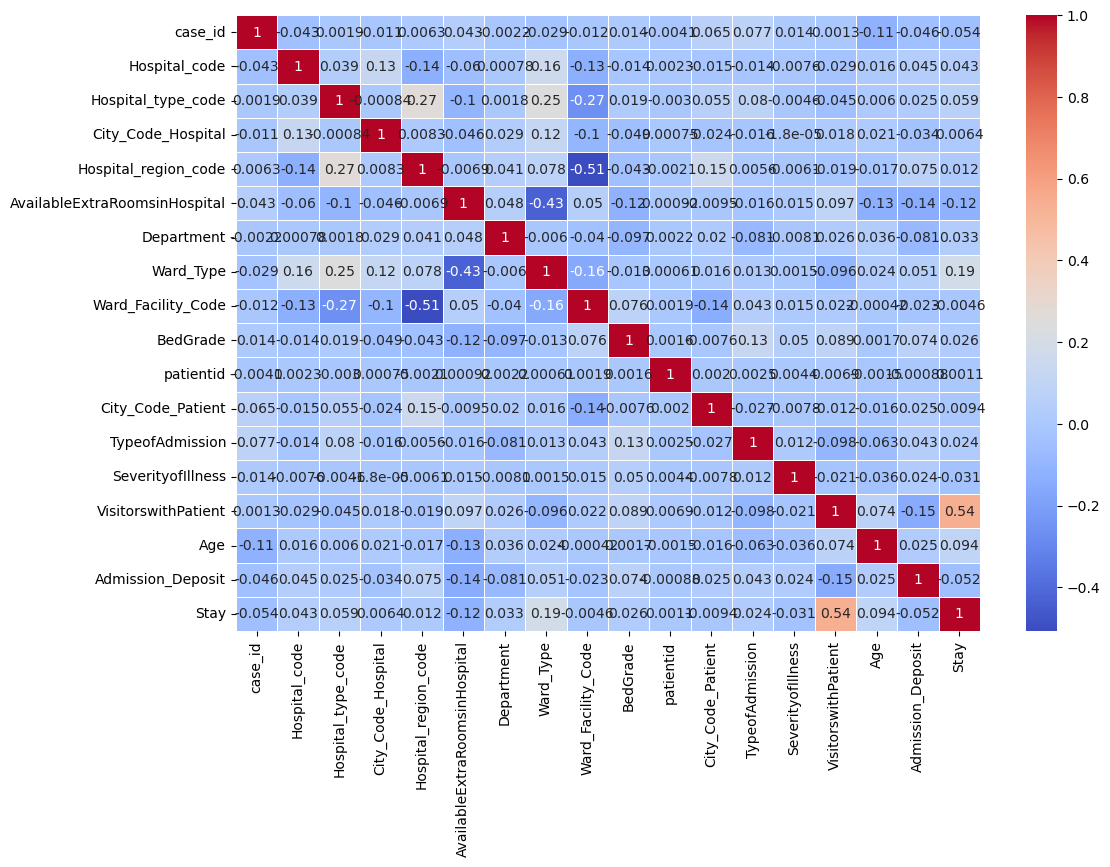

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

# Drop non-numeric columns from the DataFrame
df_transformed = df_transformed.select_dtypes(include=['number'])

# Generate the correlation matrix (this will only include numeric columns)
corr_matrix = df_transformed.corr()

# Create a heatmap with the correlation matrix
plt.figure(figsize=(12, 8))  # Optional: set the figure size
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", linewidths=0.5)

# Display the plot
plt.show()


In [14]:
# Extract the first 206,000 rows for training
df_train_split = df_transformed.iloc[:10000, :]

# Display the first few rows of the extracted data to verify
print(df_train_split.head())


   case_id  Hospital_code  Hospital_type_code  City_Code_Hospital  \
0        1              8                   2                   3   
1        2              2                   2                   5   
2        3             10                   4                   1   
3        4             26                   1                   2   
4        5             26                   1                   2   

   Hospital_region_code  AvailableExtraRoomsinHospital  Department  Ward_Type  \
0                     2                              3           3          2   
1                     2                              2           3          3   
2                     0                              2           1          3   
3                     1                              2           3          2   
4                     1                              2           3          3   

   Ward_Facility_Code  BedGrade  patientid  City_Code_Patient  \
0                   5       2.0  

In [15]:
import numpy as np
# data split in three sets, training, validation and batch inference
rand_split = np.random.rand(len(df_train_split))
train_list = rand_split < 0.66
val_list = (rand_split >= 0.66) & (rand_split < 0.83)
test_list = rand_split >= 0.83


In [20]:
#rand_split = np.random.rand(10)
#train_list = rand_split < 0.66
#val_list = (rand_split >= 0.66) & (rand_split < 0.83)
#test_list = rand_split >= 0.83
#print(rand_split)
#print(train_list)
#print(val_list)
#print(test_list)

[0.01708661 0.52678874 0.33479548 0.39729864 0.22501747 0.2362358
 0.10983399 0.28057952 0.89334547 0.3896659 ]
[ True  True  True  True  True  True  True  True False  True]
[False False False False False False False False False False]
[False False False False False False False False  True False]


# Basline SVM Model

In [16]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

# Since 'Stay' is the target variable (y) and the rest are features (X)
X = df_train_split.drop(columns=['Stay'])  # Drop the target column
y = df_train_split['Stay']  # Target column

# Split the dataset based on your train, validation, and test lists
X_train = X[train_list]
y_train = y[train_list]

X_val = X[val_list]
y_val = y[val_list]

X_test = X[test_list]
y_test = y[test_list]

# Standardize the data (SVM works better with scaled data)
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Initialize the SVM classifier
svm_model = SVC(kernel='linear')  # You can also experiment with other kernels like 'rbf' or 'poly'

# Train the SVM model on the training set
svm_model.fit(X_train_scaled, y_train)

# Validate the model on the validation set
y_val_pred = svm_model.predict(X_val_scaled)
val_accuracy = accuracy_score(y_val, y_val_pred)
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")

# Test the model on the test set
y_test_pred = svm_model.predict(X_test_scaled)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


Validation Accuracy: 38.47%
Test Accuracy: 38.43%


# Feature Store

In [148]:
# You can modify the following to use a bucket of your choosing
default_s3_bucket_name = feature_store_session.default_bucket()
prefix = "sagemaker-featurestore-demo"

print(default_s3_bucket_name)

sagemaker-us-east-1-284926681852


In [17]:
from sagemaker.session import Session

region = boto3.Session().region_name

boto_session = boto3.Session(region_name=region)

sagemaker_client = boto_session.client(service_name="sagemaker", region_name=region)
featurestore_runtime = boto_session.client(
    service_name="sagemaker-featurestore-runtime", region_name=region
)

feature_store_session = Session(
    boto_session=boto_session,
    sagemaker_client=sagemaker_client,
    sagemaker_featurestore_runtime_client=featurestore_runtime,
)

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml


NameError: name 'boto3' is not defined

In [149]:
from sagemaker import get_execution_role

# You can modify the following to use a role of your choosing. See the documentation for how to create this.
role = get_execution_role()
print(role)

arn:aws:iam::284926681852:role/LabRole


In [150]:
from time import gmtime, strftime, sleep

Hospital_Stay_feature_group_name = "hospital_store_feature_group" + strftime("%d-%H-%M-%S", gmtime())

In [154]:
from sagemaker.feature_store.feature_group import FeatureGroup

hosptialStay_feature_group = FeatureGroup(
    name=Hospital_Stay_feature_group_name, sagemaker_session=feature_store_session
)


In [159]:
import time

current_time_sec = int(round(time.time()))


# record identifier and event time feature names
record_identifier_feature_name = "case_id"
event_time_feature_name = "EventTime"

# append EventTime feature
df_transformed[event_time_feature_name] = pd.Series(
    [current_time_sec] * len(df_transformed), dtype="float64"
)



# load feature definitions to the feature group. SageMaker FeatureStore Python SDK will auto-detect the data schema based on input data.
hosptialStay_feature_group.load_feature_definitions(data_frame=df_transformed)
# output is suppressed


[FeatureDefinition(feature_name='case_id', feature_type=<FeatureTypeEnum.INTEGRAL: 'Integral'>, collection_type=None),
 FeatureDefinition(feature_name='Hospital_code', feature_type=<FeatureTypeEnum.INTEGRAL: 'Integral'>, collection_type=None),
 FeatureDefinition(feature_name='Hospital_type_code', feature_type=<FeatureTypeEnum.INTEGRAL: 'Integral'>, collection_type=None),
 FeatureDefinition(feature_name='City_Code_Hospital', feature_type=<FeatureTypeEnum.INTEGRAL: 'Integral'>, collection_type=None),
 FeatureDefinition(feature_name='Hospital_region_code', feature_type=<FeatureTypeEnum.INTEGRAL: 'Integral'>, collection_type=None),
 FeatureDefinition(feature_name='AvailableExtraRoomsinHospital', feature_type=<FeatureTypeEnum.INTEGRAL: 'Integral'>, collection_type=None),
 FeatureDefinition(feature_name='Department', feature_type=<FeatureTypeEnum.INTEGRAL: 'Integral'>, collection_type=None),
 FeatureDefinition(feature_name='Ward_Type', feature_type=<FeatureTypeEnum.INTEGRAL: 'Integral'>, col

In [160]:
def wait_for_feature_group_creation_complete(feature_group):
    status = feature_group.describe().get("FeatureGroupStatus")
    while status == "Creating":
        print("Waiting for Feature Group Creation")
        time.sleep(5)
        status = feature_group.describe().get("FeatureGroupStatus")
    if status != "Created":
        raise RuntimeError(f"Failed to create feature group {feature_group.name}")
    print(f"FeatureGroup {feature_group.name} successfully created.")


hosptialStay_feature_group.create(
    s3_uri=f"s3://{default_s3_bucket_name}/{prefix}",
    record_identifier_name=record_identifier_feature_name,
    event_time_feature_name=event_time_feature_name,
    role_arn=role,
    enable_online_store=True,
)



wait_for_feature_group_creation_complete(feature_group=hosptialStay_feature_group)


Waiting for Feature Group Creation
Waiting for Feature Group Creation
Waiting for Feature Group Creation
Waiting for Feature Group Creation
Waiting for Feature Group Creation
Waiting for Feature Group Creation
Waiting for Feature Group Creation
FeatureGroup hospital_store_feature_group26-04-23-30 successfully created.


In [161]:
hosptialStay_feature_group.describe()

{'FeatureGroupArn': 'arn:aws:sagemaker:us-east-1:284926681852:feature-group/hospital_store_feature_group26-04-23-30',
 'FeatureGroupName': 'hospital_store_feature_group26-04-23-30',
 'RecordIdentifierFeatureName': 'case_id',
 'EventTimeFeatureName': 'EventTime',
 'FeatureDefinitions': [{'FeatureName': 'case_id', 'FeatureType': 'Integral'},
  {'FeatureName': 'Hospital_code', 'FeatureType': 'Integral'},
  {'FeatureName': 'Hospital_type_code', 'FeatureType': 'Integral'},
  {'FeatureName': 'City_Code_Hospital', 'FeatureType': 'Integral'},
  {'FeatureName': 'Hospital_region_code', 'FeatureType': 'Integral'},
  {'FeatureName': 'AvailableExtraRoomsinHospital', 'FeatureType': 'Integral'},
  {'FeatureName': 'Department', 'FeatureType': 'Integral'},
  {'FeatureName': 'Ward_Type', 'FeatureType': 'Integral'},
  {'FeatureName': 'Ward_Facility_Code', 'FeatureType': 'Integral'},
  {'FeatureName': 'BedGrade', 'FeatureType': 'Fractional'},
  {'FeatureName': 'patientid', 'FeatureType': 'Integral'},
  {'

In [162]:
sagemaker_client.list_feature_groups()  # use boto client to list FeatureGroups

{'FeatureGroupSummaries': [{'FeatureGroupName': 'the_neighborhood_feature_group23-20-49-23',
   'FeatureGroupArn': 'arn:aws:sagemaker:us-east-1:284926681852:feature-group/the_neighborhood_feature_group23-20-49-23',
   'CreationTime': datetime.datetime(2024, 9, 23, 20, 49, 29, 91000, tzinfo=tzlocal()),
   'FeatureGroupStatus': 'Created',
   'OfflineStoreStatus': {'Status': 'Active'}},
  {'FeatureGroupName': 'the_neighborhood_feature_group23-20-18-03',
   'FeatureGroupArn': 'arn:aws:sagemaker:us-east-1:284926681852:feature-group/the_neighborhood_feature_group23-20-18-03',
   'CreationTime': datetime.datetime(2024, 9, 23, 20, 18, 19, 990000, tzinfo=tzlocal()),
   'FeatureGroupStatus': 'Created',
   'OfflineStoreStatus': {'Status': 'Active'}},
  {'FeatureGroupName': 'the_neighborhood_feature_group23-05-10-49',
   'FeatureGroupArn': 'arn:aws:sagemaker:us-east-1:284926681852:feature-group/the_neighborhood_feature_group23-05-10-49',
   'CreationTime': datetime.datetime(2024, 9, 23, 5, 10, 58,

In [37]:
%%html

<p><b>Shutting down your kernel for this notebook to release resources.</b></p>
<button class="sm-command-button" data-commandlinker-command="kernelmenu:shutdown" style="display:none;">Shutdown Kernel</button>
        
<script>
try {
    els = document.getElementsByClassName("sm-command-button");
    els[0].click();
}
catch(err) {
    // NoOp
}    
</script>

# Release resources

In [18]:
%%html

<p><b>Shutting down your kernel for this notebook to release resources.</b></p>
<button class="sm-command-button" data-commandlinker-command="kernelmenu:shutdown" style="display:none;">Shutdown Kernel</button>
        
<script>
try {
    els = document.getElementsByClassName("sm-command-button");
    els[0].click();
}
catch(err) {
    // NoOp
}    
</script>